## Scraping Web Data

#### Using Scrapy to look for Brooklyn apartments.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Request


class BKAPSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "BKAP"
    
    # URL(s) to start with.
    start_urls = [
        'https://newyork.craigslist.org/search/brk/aap?',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        apts = response.xpath('//p[@class="result-info"]')
            
        
        for apt in apts:
            title = apt.xpath('a/text()').extract_first()
            address = apt.xpath('span[@class="result-meta"]/span[@class="result-hood"]/text()').extract_first("")[2:-1]
            price = apt.xpath('span[@class="result-meta"]/span[@class="result-price"]/text()').extract_first()

            yield{'Price':price, 'Title':title, 'Address':address}

        next_page = response.xpath('//a[@class="button next"]/@href').extract_first()
        next_url = response.urljoin(next_page)
        
        if next_page is not None:
            yield Request(next_url, callback=self.parse)
        

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'firstpage.json',  # Name our storage file.
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(BKAPSpider)
process.start()
print('Success!')


Success!


In [5]:
import pandas as pd

df = pd.read_json('firstpage.json', orient='records')
print(df.shape)
print(df.head())

(3000, 3)
        Address  Price                                              Title
0  Clinton Hill  $3275             PRATT STUDENTS > 3bed in new building-
1      Bed-Stuy  $3350  Luxury doorman elevator building located in pr...
2  Williamsburg  $3295  --- 3bed in Williamsburg ^ Queen Size Beds ^ W...
3  Williamsburg  $2775  Amazing 2bed by the Williamsburg Bridge - H/HW...
4      Bushwick  $2950  Large 3bd/1.5ba with skylights/laundry/large l...


In [6]:
# display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
Address    3000 non-null object
Price      2998 non-null object
Title      3000 non-null object
dtypes: object(3)
memory usage: 70.4+ KB


In [7]:
# drop na
df = df.dropna()

In [16]:
# define function to clean price data
def price_cleaner(text):
    text = re.sub('\$', '', text)
    return int(text)

In [17]:
df['Price'] = df['Price'].apply(price_cleaner)

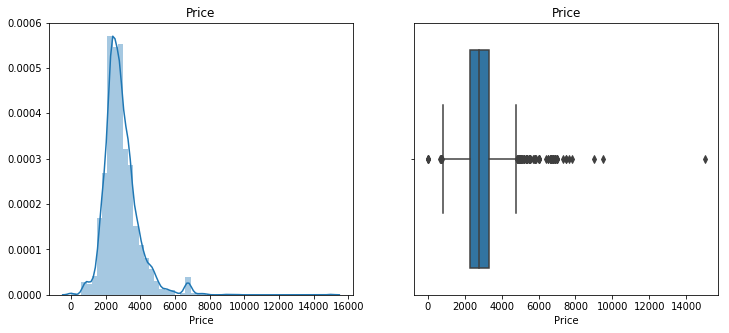

In [18]:
# display distribution of price variable
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['Price'])
plt.title('Price')

plt.subplot(1, 2, 2)
sns.boxplot(df['Price'])
plt.title('Price')

plt.show()